<a href="https://colab.research.google.com/github/UlitiM2/tasks_university/blob/master/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%2C%20%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5/lab4_Ulitina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Данная лабораторная посвящена работе с текстовыми данными.

Для общего развития (или если возникнут проблемы при выполнении заданий) рекомендуется ознакомиться с материалами курса по NLP, в частности с блокнотами 2 и 4:

1. [Вводная часть](https://colab.research.google.com/drive/1Fc9mAY-d-uA_x0naBQHYjbOSD7JyS0bf)

2. [Предобработка текста](https://colab.research.google.com/drive/1Lk4GcoS8KlXqjPXX6vK1teYbzaV5hNV8)

3. [Анализ и визуализация текстовых данных](https://colab.research.google.com/drive/1LoDu-ZvC4cKnfQTcgq_4Ya5gKmDyKg96)

4. [Векторизация](https://colab.research.google.com/drive/1n71YET2VbYIwyY0jYC5G1Zlkgl5ZInJ9)

5. [Другие задачи в области NLP](https://colab.research.google.com/drive/1u5IjpGisDXd_XH96lKTadJ8rKsg3VXD5)

Если вкратце, то компьютер умеет работать только с числами, а текст - это не числа, поэтому основная задача NLP - эффективно превратить текст в набор чисел (векторизовать). В идеале мы стремимся к тому, чтобы сохранить смысловую составляющую.

Важный факт, на который вы можете опираться при выполнении заданий:

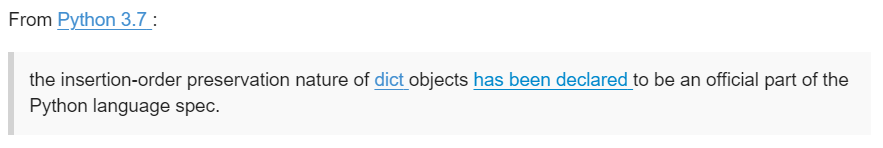

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import requests
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from collections import Counter

# Анализ текстовых данных

## Данные (3 балла)

Задача, которую мы будем пытаться решить, представляет собой классификацию коротких текстов по доменным областям знания, которым они принадлежат. Доменных областей (domain) будет 4. Данные возьмем с [OpenAlex](https://docs.openalex.org/).

Соберите не менее 10k англоязычных записей с OpenAlex. Для каждой записи сохраните поля `id`, `title`, `abstract`, `domain`. Сохраняйте только те записи, у которых присутствуют все необходимые поля. Вероятно, вам пригодится [эта страница](https://docs.openalex.org/how-to-use-the-api/get-lists-of-entities/paging) документации.

In [ ]:
def invert_abstract(inverted_index):
    if not inverted_index:
        return ""

    words = []
    for word, positions in inverted_index.items():
        words.extend((pos, word) for pos in positions)

    return ' '.join(word for _, word in sorted(words))

def fetch_openalex_data(min_records=10000):
    base_url = "https://api.openalex.org/works"
    target_domains = ["Computer science", "Medicine", "Psychology", "Biology"]
    params = {
        "filter": "language:en,has_abstract:true",
        "select": "id,title,abstract_inverted_index,concepts",
        "per-page": 200,
        "cursor": "*"
    }

    records = []
    while len(records) < min_records:
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()

            for work in data['results']:
                domains = [c['display_name'] for c in work.get('concepts', [])
                          if c.get('display_name') in target_domains]

                if domains and work.get('abstract_inverted_index') and work['title']:
                    records.append({
                        'id': work['id'],
                        'title': work['title'],
                        'abstract': invert_abstract(work.get('abstract_inverted_index')),
                        'domain': domains[0]
                    })

            params['cursor'] = data['meta']['next_cursor']

        except Exception as e:
            print(f"Error occurred: {e}")
            break

    return pd.DataFrame(records)

df = fetch_openalex_data(min_records=10000)
df.to_csv('openalex_domain_classification.csv', index=False)
print(f"Collected {len(df)} records")
display(df.head())

Collected 10023 records


,id,title,abstract,domain
0,https://openalex.org/W2194775991,Deep Residual Learning for Image Recognition,Deeper neural networks are more difficult to t...,Computer science
1,https://openalex.org/W1979290264,Using thematic analysis in psychology,Abstract Thematic analysis is a poorly demarca...,Psychology
2,https://openalex.org/W2144634347,Molecular Cloning: A Laboratory Manual,Molecular Cloning has served as the foundation...,Computer science
3,https://openalex.org/W2159011576,Diagnostic and Statistical Manual of Mental Di...,The fifth edition of the <italic>Diagnostic an...,Psychology
4,https://openalex.org/W2110065044,Controlling the False Discovery Rate: A Practi...,SUMMARY The common approach to the multiplicit...,Computer science


Изучите собранные данные. Минимально выведите следующую информацию:

* общее количество записей;

* количество уникальных значений (какие и сколько) для доменных областей;

* распределение количества символов и количества слов для `title` и `abstract`.

In [ ]:
print(f"Общее количество записей: {len(df)}")
domain_counts = df['domain'].value_counts()
print("\nКоличество записей по доменным областям:")
print(domain_counts)

df['title_length'] = df['title'].str.len()
df['title_word_count'] = df['title'].str.split().str.len()
df['abstract_length'] = df['abstract'].str.len()
df['abstract_word_count'] = df['abstract'].str.split().str.len()

print("\nРаспределение для title:")
print(f"Средняя длина в символах: {df['title_length'].mean():.1f}")
print(f"Среднее количество слов: {df['title_word_count'].mean():.1f}")
print("\nРаспределение для abstract:")
print(f"Средняя длина в символах: {df['abstract_length'].mean():.1f}")
print(f"Среднее количество слов: {df['abstract_word_count'].mean():.1f}")


Общее количество записей: 10022

Количество записей по доменным областям:
domain
Computer science    4574
Biology             1973
Medicine            1799
Psychology          1676
Name: count, dtype: int64

Распределение для title:
Средняя длина в символах: 66.7
Среднее количество слов: 8.8

Распределение для abstract:
Средняя длина в символах: 1222.0
Среднее количество слов: 176.1


Напишите функцию для предобработки текстовых данных. Она должна включать следующие шаги:

1. приведение текста к нижнему регистру;

2. удаление пунктуации и чисел;

3. лемматизация;

4. удаление стоп-слов;

5. удаление лишних пробельных символов.

Объедините `title` и `abstract` в один текст. Проведите его предобработку.

In [ ]:
del df["title_length"]
del df["title_word_count"]
del df["abstract_length"]
del df["abstract_word_count"]

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(text):
    """
    Функция для предобработки текста:
    1. Приведение к нижнему регистру
    2. Удаление пунктуации и чисел
    3. Лемматизация
    4. Удаление стоп-слов
    5. Удаление лишних пробелов
    """
    if not isinstance(text, str) or not text.strip():
        return ""

    try:
        text = text.lower()

        text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
        text = re.sub(r'\d+', ' ', text)

        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in lemmatized_tokens if word not in stop_words]

        preprocessed_text = ' '.join(filtered_tokens).strip()
        preprocessed_text = re.sub(r'\s+', ' ', preprocessed_text)

        return preprocessed_text
    except Exception as e:
        print(f"Error processing text: {e}")
        return ""

def combine_and_preprocess(row):
    combined_text = f"{row['title']} {row['abstract']}"
    return preprocess_text(combined_text)

def combine(row):
    combined_text = f"{row['title']} {row['abstract']}"
    return combined_text

df['title_abstract'] = df.apply(combine, axis=1)
df['title_abstract_preprocessed'] = df.apply(combine_and_preprocess, axis=1)
display(df.head())

,id,title,abstract,domain,title_abstract,title_abstract_preprocessed
0,https://openalex.org/W2194775991,Deep Residual Learning for Image Recognition,Deeper neural networks are more difficult to t...,Computer science,Deep Residual Learning for Image Recognition D...,deep residual learning image recognition deepe...
1,https://openalex.org/W1979290264,Using thematic analysis in psychology,Abstract Thematic analysis is a poorly demarca...,Psychology,Using thematic analysis in psychology Abstract...,using thematic analysis psychology abstract th...
2,https://openalex.org/W2144634347,Molecular Cloning: A Laboratory Manual,Molecular Cloning has served as the foundation...,Computer science,Molecular Cloning: A Laboratory Manual Molecul...,molecular cloning laboratory manual molecular ...
3,https://openalex.org/W2159011576,Diagnostic and Statistical Manual of Mental Di...,The fifth edition of the <italic>Diagnostic an...,Psychology,Diagnostic and Statistical Manual of Mental Di...,diagnostic statistical manual mental disorder ...
4,https://openalex.org/W2110065044,Controlling the False Discovery Rate: A Practi...,SUMMARY The common approach to the multiplicit...,Computer science,Controlling the False Discovery Rate: A Practi...,controlling false discovery rate practical pow...


In [ ]:
df.to_csv('openalex_domain_classification.csv', index=False)

В качестве алгоритма классификации будем использовать Наивный Байес (`MultinomialNB`) и `LinearSVC` с фиксированным `random_state`=42.

Для оценки разделите ваши данные в соотношении 80:20. Сделайте это ДО проведения любой векторизации. Общее правило, чтобы понять, можно применять обработку до разделения или только после - если ваша предобработка работает с каждой записью независимо, то можно пременить её до разделения. Иначе, если при обработке одной записи используется какая-либо информация из других записей (среднее, уникальные значения, общее кол-во и так далее), применять её рекомендуется только после разделения.

При оценке используйте `classification_report` и `confusion_matrix` (для визуализации пригодится `seaborn.heatmap`).

=== MultinomialNB Report ===
                  precision    recall  f1-score   support

         Biology       0.92      0.53      0.67       395
Computer science       0.65      1.00      0.79       915
        Medicine       0.93      0.72      0.81       360
      Psychology       0.97      0.26      0.41       335

        accuracy                           0.73      2005
       macro avg       0.87      0.63      0.67      2005
    weighted avg       0.81      0.73      0.71      2005

=== LinearSVC Report ===
                  precision    recall  f1-score   support

         Biology       0.86      0.79      0.82       395
Computer science       0.84      0.89      0.87       915
        Medicine       0.86      0.82      0.84       360
      Psychology       0.74      0.73      0.74       335

        accuracy                           0.83      2005
       macro avg       0.83      0.81      0.82      2005
    weighted avg       0.83      0.83      0.83      2005



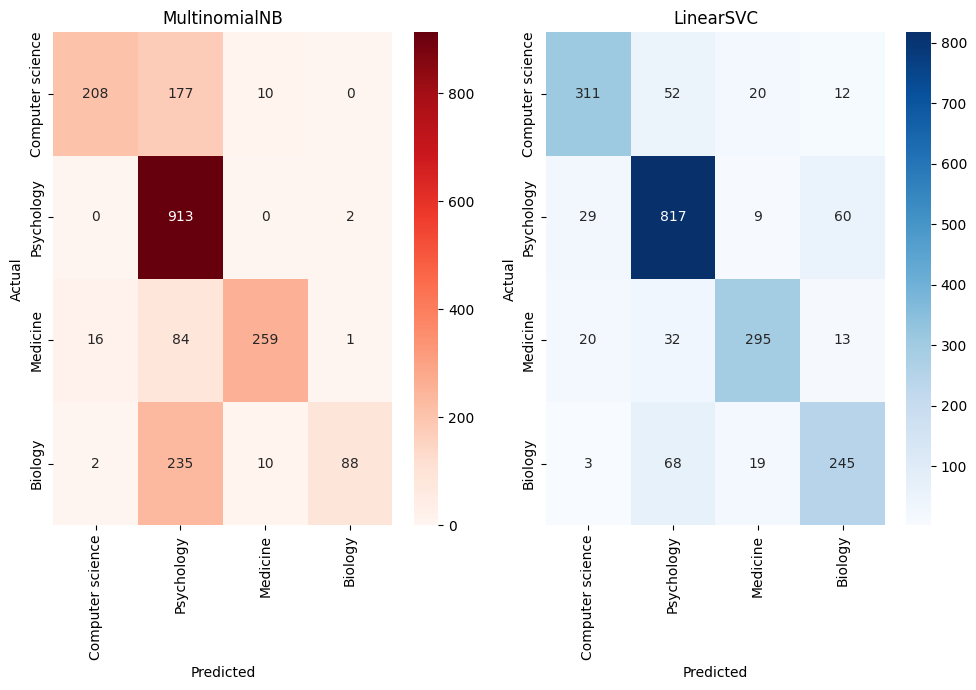

In [ ]:
X = df['title_abstract_preprocessed']
y = df['domain']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf1 = MultinomialNB()
clf2 = LinearSVC(random_state=42)
clf1.fit(X_train_vec, y_train)
clf2.fit(X_train_vec, y_train)


y_pred_nb = clf1.predict(X_test_vec)
print("=== MultinomialNB Report ===")
print(classification_report(y_test, y_pred_nb))
y_pred_svc = clf2.predict(X_test_vec)
print("=== LinearSVC Report ===")
print(classification_report(y_test, y_pred_svc))

cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_svc = confusion_matrix(y_test, y_pred_svc)


plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap="Reds", xticklabels=df['domain'].unique(), yticklabels=df['domain'].unique())
plt.title("MultinomialNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.subplot(1, 2, 2)
sns.heatmap(cm_svc, annot=True, fmt='d', cmap="Blues", xticklabels=df['domain'].unique(), yticklabels=df['domain'].unique())
plt.title("LinearSVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Bag of Words (3 балла)

"Мешок слов" (Bag of Words, BoW) — это самый простой подход к векторизации текста.

Порядок слов не учитывается, а вся информация об анализируемом тексте сосредоточена в частоте встречаемости слов.
```
docs = [
  {'word1': 2, 'word2': 0, 'word3': 8, ...},
  {'word1': 1, 'word2': 0, 'word3': 2, ...},
  ...
  ]

len(docs[i].keys()) = общее кол-во слов ('word1', 'word2', 'word3', ...) в корпусе
docs[i] - представление i-того документа
```

Основные шаги алгоритма:

1. токенизация;

2. fit: построение словаря: создание словаря из всех уникальных слов, встречающихся в корпусе;

3. transform: подсчет частоты: для каждого слова из словаря подсчитывается, сколько раз оно встречается в тексте.

Допишите класс со следующей сигнатурой (можно добавить ещё методы). Работать будем только со словами. Параметр max_features отвечает за фиксированную длину вектора (подумайте, как длина вектора связана с объемом словаря).

In [ ]:
from collections import Counter
import re

class BagOfWords:
    def __init__(self, ngram_range=(1, 1), max_features=None):
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.vocabulary = {}
        self.token_pattern = re.compile(r"(?u)\b\w+\b")

    def fit(self, documents):
        ngrams = []
        min_n, max_n = self.ngram_range

        for doc in documents:
            tokens = self.tokenize(doc)
            for n in range(min_n, max_n + 1):
                ngrams.extend([' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)])

        counter = Counter(ngrams)
        most_common = counter.most_common(self.max_features) if self.max_features else counter.items()
        self.vocabulary = {term: idx for idx, (term, _) in enumerate(most_common)}

    def transform(self, documents):
        if not len(self.vocabulary):
            raise ValueError("The vocabulary has not been created. Call fit method first.")

        vectors = []
        min_n, max_n = self.ngram_range

        for doc in documents:
            vector = [0] * len(self.vocabulary)
            tokens = self.tokenize(doc)

            doc_ngrams = []
            for n in range(min_n, max_n + 1):
                doc_ngrams.extend([' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)])

            for ngram in doc_ngrams:
                if ngram in self.vocabulary:
                    vector[self.vocabulary[ngram]] += 1

            vectors.append(vector)

        return vectors

    def fit_transform(self, documents):
        self.fit(documents)
        return self.transform(documents)

    def tokenize(self, text):
        return self.token_pattern.findall(text.lower())

In [ ]:
bow = BagOfWords(ngram_range=(1, 2), max_features=15)

test_sentences = [
    "BoW transforms text into a frequency vector based on words occurrence",
    "in BoW each word's count creates a unique feature",
    "BoW ignores word order focusing on word occurrence frequency",
]

vectors = bow.fit_transform(test_sentences)
pd.DataFrame(vectors, columns=list(bow.vocabulary.keys()))

,bow,word,a,frequency,on,occurrence,transforms,text,into,vector,based,words,bow transforms,transforms text,text into
0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2,0,1,1,1,0,0,0,0,0,0,0,0,0


Векторизуйте тексты с помощью вашего алгоритма. Обучите классификатор и оцените скорость работы и качество классификации по доменным областям (domain). Поэкспериментируйте с гиперпараметрами вашего векторайзера.

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


=== MultinomialNB Report ===
                  precision    recall  f1-score   support

         Biology       0.70      0.85      0.77       403
Computer science       0.93      0.66      0.77       936
        Medicine       0.88      0.79      0.83       325
      Psychology       0.56      0.91      0.69       341

        accuracy                           0.76      2005
       macro avg       0.77      0.80      0.77      2005
    weighted avg       0.81      0.76      0.77      2005

=== LinearSVC Report ===
                  precision    recall  f1-score   support

         Biology       0.74      0.70      0.72       403
Computer science       0.82      0.80      0.81       936
        Medicine       0.75      0.79      0.77       325
      Psychology       0.66      0.70      0.68       341

        accuracy                           0.76      2005
       macro avg       0.74      0.75      0.74      2005
    weighted avg       0.76      0.76      0.76      2005



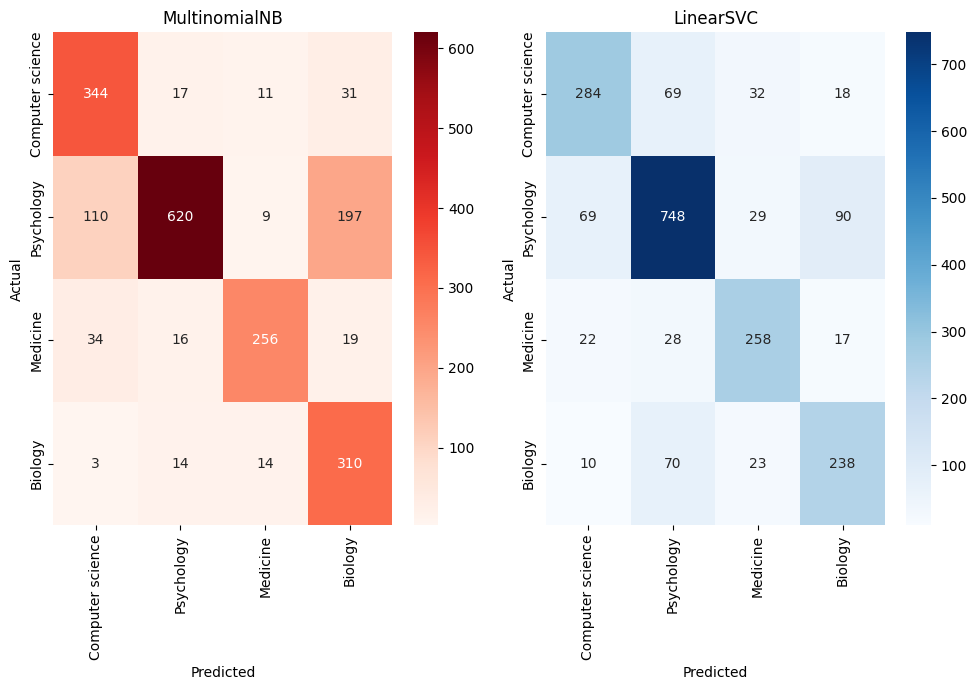


Vectorization Time: 4.3264 seconds


In [ ]:
X = df['title_abstract_preprocessed']
y = df['domain']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


bow = BagOfWords(ngram_range=(1, 3), max_features=1500)
start_time = time.time()
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)
vectorization_time = time.time() - start_time


clf1 = MultinomialNB()
clf1.fit(X_train_bow, y_train)

clf2 = LinearSVC(random_state=42)
clf2.fit(X_train_bow, y_train)

y_pred_nb = clf1.predict(X_test_bow)
y_pred_svc = clf2.predict(X_test_bow)

print("=== MultinomialNB Report ===")
print(classification_report(y_test, y_pred_nb))
print("=== LinearSVC Report ===")
print(classification_report(y_test, y_pred_svc))

cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_svc = confusion_matrix(y_test, y_pred_svc)


plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Reds", xticklabels=df['domain'].unique(), yticklabels=df['domain'].unique())
plt.title("MultinomialNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.subplot(1, 2, 2)
sns.heatmap(cm_svc, annot=True, fmt="d", cmap="Blues", xticklabels=df['domain'].unique(), yticklabels=df['domain'].unique())
plt.title("LinearSVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print(f"\nVectorization Time: {vectorization_time:.4f} seconds")

Воспользуйтесь готовой реализацией CountVectorizer из sklearn. Сопоставимые ли результаты получаются? Подберите гиперпараметры с помощью GridSearch.

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best params for MultinomialNB pipeline: {'classifier__alpha': 0.1, 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 1)}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Best params for LinearSVC pipeline: {'classifier__C': 0.1, 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 1)}

=== MultinomialNB Report ===
                  precision    recall  f1-score   support

         Biology       0.81      0.79      0.80       419
Computer science       0.87      0.82      0.84       894
        Medicine       0.90      0.78      0.83       363
      Psychology       0.65      0.87      0.75       329

        accuracy                           0.81      2005
       macro avg       0.81      0.81      0.80      2005
    weighted avg       0.82      0.81      0.81      2005

Training time: 747.09 seconds

=== LinearSVC Report ===
                  precision    recall  f1-score   support

         Biology       0.83      0.75      0.79       419
Computer science       0.82      0.88      0.85       894
        Medicine       0.86      0.80      0.83       363
      Psychology       0.73      0.73      0.73       329

        accuracy         

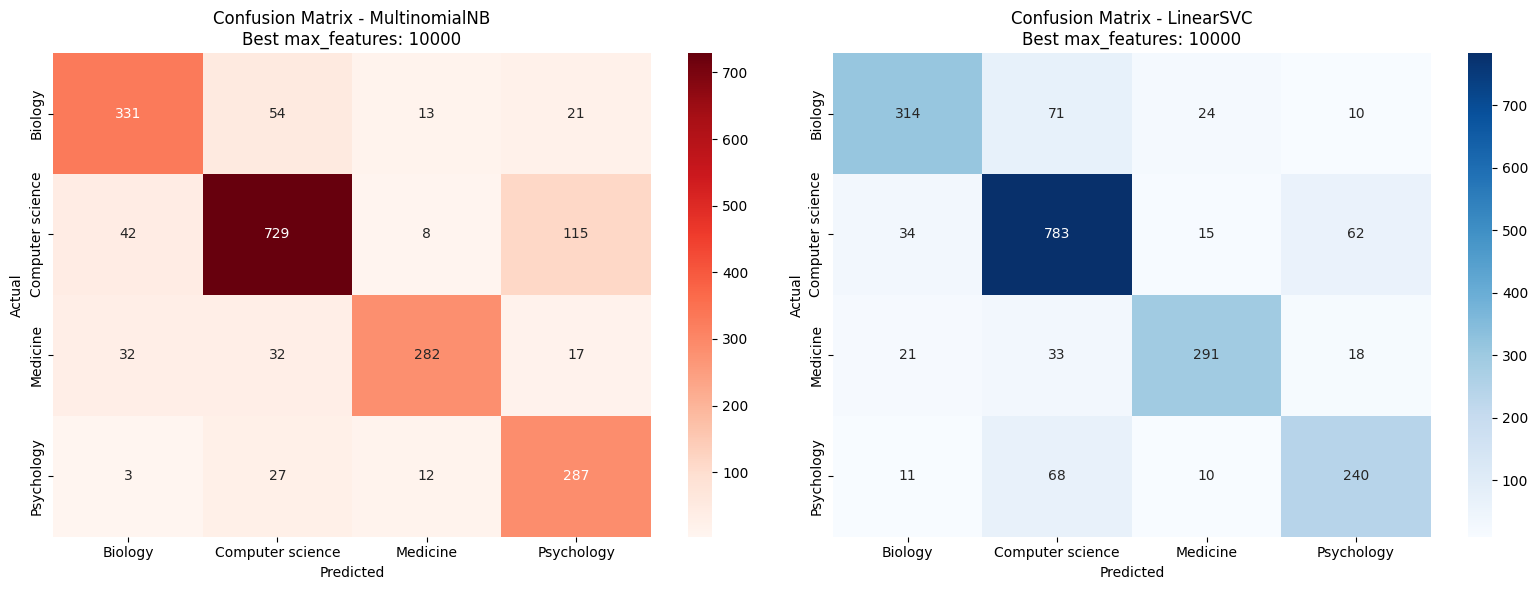

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import time
from sklearn.pipeline import Pipeline

X = df['title_abstract_preprocessed']
y = df['domain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'vectorizer__max_features': [1000, 3000, 5000, 7000, 10000],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 2)],
    'classifier__alpha': [0.1, 0.5, 1.0, 2.0]
}

pipeline_nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])


grid_search_nb = GridSearchCV(pipeline_nb, param_grid, cv=5, n_jobs=-1, verbose=1)
start_time = time.time()
grid_search_nb.fit(X_train, y_train)
nb_time = time.time() - start_time

print(f"\nBest params for MultinomialNB pipeline: {grid_search_nb.best_params_}")
best_nb = grid_search_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test)

param_grid_svc = {
    'vectorizer__max_features': [1000, 3000, 5000, 7000, 10000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1, 1.0, 10.0]
}

pipeline_svc = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LinearSVC(random_state=42))
])

grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, n_jobs=-1, verbose=1)
start_time = time.time()
grid_search_svc.fit(X_train, y_train)
svc_time = time.time() - start_time

print(f"\nBest params for LinearSVC pipeline: {grid_search_svc.best_params_}")
best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test)

print("\n=== MultinomialNB Report ===")
print(classification_report(y_test, y_pred_nb))
print(f"Training time: {nb_time:.2f} seconds")

print("\n=== LinearSVC Report ===")
print(classification_report(y_test, y_pred_svc))
print(f"Training time: {svc_time:.2f} seconds")


plt.figure(figsize=(16, 6))
classes = np.unique(y)

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_nb),
            annot=True, fmt='d', cmap="Reds",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - MultinomialNB\nBest max_features: {}".format(
    grid_search_nb.best_params_['vectorizer__max_features']))
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_svc),
            annot=True, fmt='d', cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - LinearSVC\nBest max_features: {}".format(
    grid_search_svc.best_params_['vectorizer__max_features']))
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

### Keywords (0.5 балла)

Выведите топ-20 ключевых слов для каждого домена (то есть таких, которые превалируют именно в конкретном домене) и общие топ-20 слов по всем доменам. Используйте `CountVectorizer`.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['title_abstract_preprocessed'])
feature_names = vectorizer.get_feature_names_out()

total_counts = np.array(X.sum(axis=0)).flatten()
top_global_indices = total_counts.argsort()[-20:][::-1]

print("=== Топ-20 самых частых слов по всем доменам ===")
for idx in top_global_indices:
    print(f"{feature_names[idx]}: {total_counts[idx]}")


domains = df['domain'].unique()
for domain in domains:
    domain_mask = (df['domain'] == domain)
    domain_counts = np.array(X[domain_mask].sum(axis=0)).flatten()

    top_indices = domain_counts.argsort()[-20:][::-1]

    print(f"\n=== Топ-20 слов для домена '{domain}' ===")
    for idx in top_indices:
        print(f"{feature_names[idx]}: {domain_counts[idx]}")

=== Топ-20 самых частых слов по всем доменам ===
data: 6034
model: 5471
method: 5148
analysis: 5137
study: 4901
wa: 4612
research: 4422
ha: 4116
system: 3811
patient: 3796
new: 3728
cell: 3308
based: 3168
theory: 3024
also: 2881
result: 2865
disease: 2755
used: 2676
using: 2672
information: 2644

=== Топ-20 слов для домена 'Computer science' ===
model: 3573
data: 3538
method: 3272
analysis: 2755
system: 2289
network: 2068
research: 2055
problem: 1915
new: 1891
article: 1814
information: 1802
ha: 1798
algorithm: 1694
based: 1579
theory: 1554
application: 1491
using: 1374
approach: 1365
result: 1318
learning: 1294

=== Топ-20 слов для домена 'Psychology' ===
research: 1492
study: 1233
theory: 1164
social: 1117
self: 945
analysis: 763
model: 724
wa: 637
behavior: 617
ha: 592
effect: 582
scale: 567
process: 565
learning: 510
cognitive: 488
development: 475
test: 473
group: 465
individual: 464
part: 458

=== Топ-20 слов для домена 'Medicine' ===
patient: 3457
wa: 2536
disease: 2097
cancer: 

## TF-IDF (3 балла)

TF-IDF представляет собой числовую статистику, отражающую важность слова в документе относительно коллекции документов (корпуса). Мы всё еще считаем частоту слов, но теперь делаем это более по-умному.

Оценка TF-IDF вычисляется с использованием двух основных компонент: частоты термина (TF) и обратной частоты документа (IDF).

1. **TF**
   
   Измеряет, насколько часто термин (слово) встречается в документе. Рассчитывается как отношение числа раз, когда термин появляется в документе, к общему числу терминов в этом документе.
   
   $$ \text{TF}(t, d) = \frac{\text{Количество раз, когда термин } t \text{ появляется в документе } d}{\text{Общее количество терминов в документе } d} $$

2. **IDF**
   
   Измеряет важность термина по всему корпусу. Она рассчитывается как логарифм отношения общего числа документов к числу документов, содержащих термин, плюс единица для избежания деления на ноль.

   $$ \text{IDF}(t, D) = \log\left(\frac{\text{Общее количество документов в корпусе } N}{\text{Количество документов, содержащих термин } t + 1} \right) $$

   Здесь \(N\) - общее количество документов в корпусе.
   Логарифм нужен для сглаживания.

   **P.S.** В sklearn используется формула $$ \text{IDF}(t, D) = \log\left(\frac{\text{Общее количество документов в корпусе } N + 1}{\text{Количество документов, содержащих термин } t + 1} \right) + 1 $$

   В вашей реализации нужно будет использовать именно её.

3. **Оценка TF-IDF:**
   
   $$ \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D) $$

   Эта оценка присваивает более высокий вес терминам, часто встречающимся в конкретном документе, но относительно редким в общей коллекции документов.

Ваша задача - реализовать класс со следующей сигнатурой (можно менять или добавлять методы при необходимости) для векторизации с помощью TF-IDF подхода. Используйте разбиение только по словам. При отборе `max_features` ориентируйтесь на term frequency.

In [ ]:
import math
import re
from collections import defaultdict
from collections import Counter
import pandas as pd


class TFIDF:
    """
    TF-IDF модель для векторизации текстовых данных.

    Параметры:
        ngram_range (tuple): Диапазон n-грамм для создания признаков.
        max_features (int): Максимальное количество признаков для использования.

    Атрибуты:
        ngram_range (tuple): Диапазон n-грамм для создания признаков.
        max_features (int): Максимальное количество признаков для использования.
        vocabulary (dict): Словарь, сопоставляющий токены их tf-idf значениям.
    """

    def __init__(self, ngram_range=(1, 1), max_features=None):
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.vocabulary = {}
        self.idf_scores = {}

    def fit(self, documents):
        """
        Создает словарь на основе предоставленных документов.

        Параметры:
            documents (list): Список текстовых документов.
        """
        term_freq = Counter()
        doc_freq = defaultdict(int)
        total_docs = len(documents)
        all_ngrams = []

        for doc in documents:
            tokens = self.tokenize(doc)
            ngrams = self.generate_ngrams(tokens)
            all_ngrams.append(ngrams)
            term_freq.update(ngrams)
            for term in set(ngrams):
                doc_freq[term] += 1

        most_common = term_freq.most_common(self.max_features)
        self.vocabulary = {term: idx for idx, (term, _) in enumerate(most_common)}

        for term in self.vocabulary:
            self.idf_scores[term] = math.log((1 + total_docs) / (1 + doc_freq[term])) + 1

    def transform(self, documents):
        """
        Преобразует текстовые документы в векторное представление с использованием созданного словаря.

        Параметры:
            documents (list): Список текстовых документов.

        Возвращает:
            list: Векторное представление документов.
        """
        if not len(self.vocabulary):
            raise ValueError("The vocabulary has not been created. Call fit method first.")

        vectors = []

        for doc in documents:
            tokens = self.tokenize(doc)
            ngrams = self.generate_ngrams(tokens)
            tf_counter = Counter(ngrams)

            vector = [0.0] * len(self.vocabulary)

            for term, idx in self.vocabulary.items():
                tf = tf_counter[term]
                idf = self.idf_scores.get(term, 0)
                vector[idx] = tf * idf

            vectors.append(vector)

        return vectors


    def fit_transform(self, documents):
        """
        Обучает модель на предоставленных документах и возвращает их векторное представление.

        Параметры:
            documents (list): Список текстовых документов.

        Возвращает:
            list: Векторное представление документов.
        """
        self.fit(documents)
        return self.transform(documents)

    def tokenize(self, text):
        """
        Разбивает текст на токены.

        Параметры:
            text (str): Текст для токенизации.

        Возвращает:
            list: Список токенов.
        """
        return re.findall(r'\b\w+\b', text.lower())

    def generate_ngrams(self, tokens):
        min_n, max_n = self.ngram_range
        ngrams = []
        for n in range(min_n, max_n + 1):
            ngrams.extend([' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)])
        return ngrams

In [ ]:
tfidf = TFIDF(ngram_range=(1, 2), max_features=15)

test_sentences = [
    "tf-idf measures word importance relative to its frequency in a document",
    "tf-idf considers word uniqueness across all documents in the corpus",
    "it identifies significant words common in a document yet rare across all documents"
]

vectors = tfidf.fit_transform(test_sentences)
pd.DataFrame(vectors, columns=list(tfidf.vocabulary.keys()))

,in,tf,idf,word,a,document,tf idf,in a,a document,across,all,documents,across all,all documents,measures
0,1.0,1.287682,1.287682,1.287682,1.287682,1.287682,1.287682,1.287682,1.287682,0.000000,0.000000,0.000000,0.000000,0.000000,1.693147
1,1.0,1.287682,1.287682,1.287682,0.000000,0.000000,1.287682,0.000000,0.000000,1.287682,1.287682,1.287682,1.287682,1.287682,0.000000
2,1.0,0.000000,0.000000,0.000000,1.287682,1.287682,0.000000,1.287682,1.287682,1.287682,1.287682,1.287682,1.287682,1.287682,0.000000


Векторизуйте тексты с помощью вашего алгоритма. Обучите классификатор и оцените скорость работы и качество классификации по доменным областям (domain). Поэкспериментируйте с гиперпараметрами вашего векторайзера.

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


=== MultinomialNB Report ===
                  precision    recall  f1-score   support

         Biology       0.74      0.84      0.79       419
Computer science       0.91      0.71      0.80       894
        Medicine       0.90      0.74      0.81       363
      Psychology       0.56      0.91      0.70       329

        accuracy                           0.78      2005
       macro avg       0.78      0.80      0.77      2005
    weighted avg       0.82      0.78      0.78      2005

=== LinearSVC Report ===
                  precision    recall  f1-score   support

         Biology       0.77      0.73      0.75       419
Computer science       0.80      0.84      0.82       894
        Medicine       0.81      0.77      0.79       363
      Psychology       0.69      0.69      0.69       329

        accuracy                           0.78      2005
       macro avg       0.77      0.76      0.76      2005
    weighted avg       0.78      0.78      0.78      2005



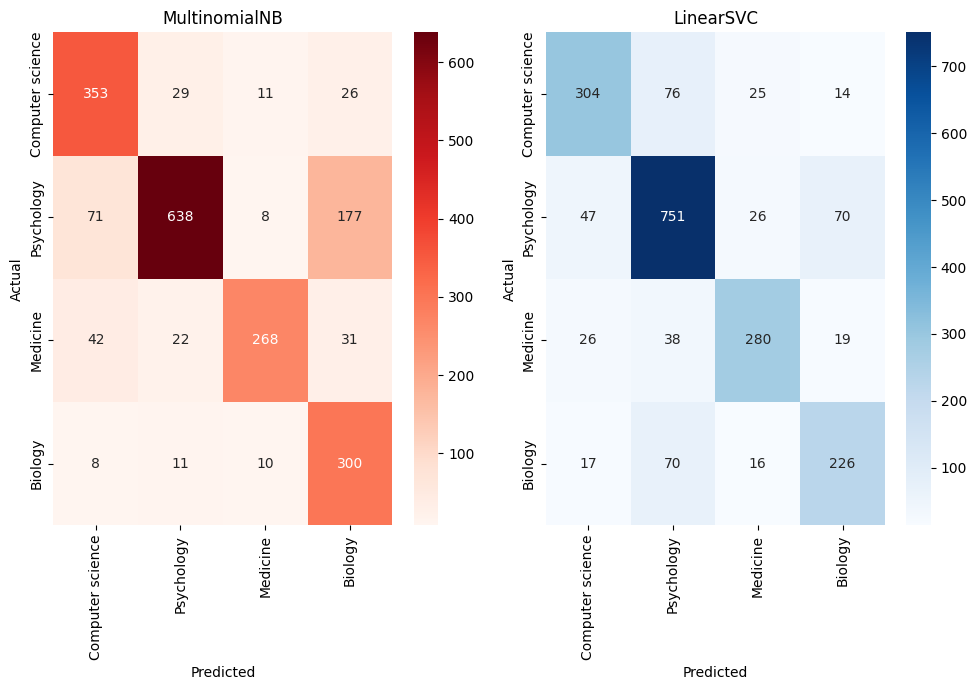


Vectorization Time: 23.0647 seconds


In [ ]:
X = df['title_abstract_preprocessed']
y = df['domain']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


start_time = time.time()
tfidf = TFIDF(ngram_range= (1,3), max_features= 3000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)
vectorization_time = time.time() - start_time


clf1 = MultinomialNB()
clf1.fit(X_train_vec, y_train)

clf2 = LinearSVC(random_state=42)
clf2.fit(X_train_vec, y_train)

y_pred_nb = clf1.predict(X_test_vec)
y_pred_svc = clf2.predict(X_test_vec)


print("=== MultinomialNB Report ===")
print(classification_report(y_test, y_pred_nb))
print("=== LinearSVC Report ===")
print(classification_report(y_test, y_pred_svc))


cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_svc = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Reds", xticklabels=df['domain'].unique(), yticklabels=df['domain'].unique())
plt.title("MultinomialNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.subplot(1, 2, 2)
sns.heatmap(cm_svc, annot=True, fmt="d", cmap="Blues", xticklabels=df['domain'].unique(), yticklabels=df['domain'].unique())
plt.title("LinearSVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
print(f"\nVectorization Time: {vectorization_time:.4f} seconds")

Воспользуйтесь готовой реализацией TfIdfVectorizer из sklearn. Сопоставимые ли результаты получаются? Подберите гиперпараметры с помощью GridSearch.

In [ ]:
df = pd.read_csv('openalex_domain_classification.csv')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params for MultinomialNB: {'alpha': 2.0}
Best params for LinearSVC: {'C': 0.1}
=== MultinomialNB Report ===
                  precision    recall  f1-score   support

         Biology       0.82      0.77      0.79       396
Computer science       0.82      0.88      0.85       914
        Medicine       0.85      0.78      0.81       360
      Psychology       0.75      0.71      0.73       335

        accuracy                           0.81      2005
       macro avg       0.81      0.79      0.80      2005
    weighted avg       0.81      0.81      0.81      2005

=== LinearSVC Report ===
                  precision    recall  f1-score   support

         Biology       0.84      0.74      0.79       396
Computer science       0.81      0.92      0.86       914
        Medicine       0.84      0.79      0.81       360
      Psychology       0.80      0.66     

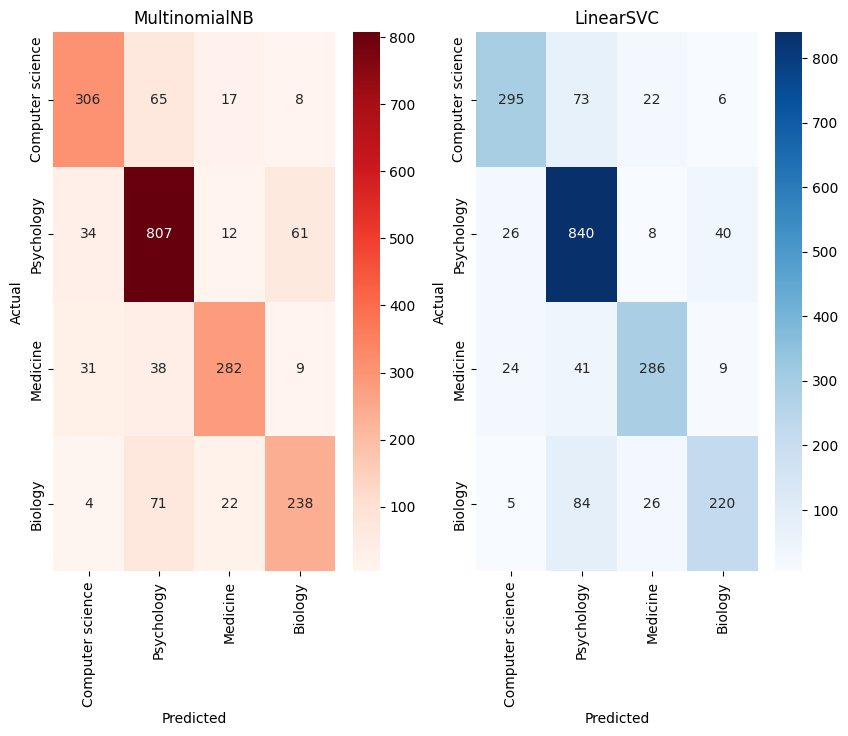


Vectorization Time: 11.8139 seconds


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


X = df['title_abstract_preprocessed']
y = df['domain']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

start_time = time.time()
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1500)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
vectorization_time = time.time() - start_time


param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
}

param_grid_svc = {
    'C': [0.1, 1.0, 10.0],
}

grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, verbose=1, n_jobs=-1)
grid_search_nb.fit(X_train_vec, y_train)


grid_search_svc = GridSearchCV(LinearSVC(random_state=42), param_grid_svc, cv=5, verbose=1, n_jobs=-1)
grid_search_svc.fit(X_train_vec, y_train)

print(f"Best params for MultinomialNB: {grid_search_nb.best_params_}")
clf1 = grid_search_nb.best_estimator_
clf1.fit(X_train_vec, y_train)

print(f"Best params for LinearSVC: {grid_search_svc.best_params_}")
clf2 = grid_search_svc.best_estimator_
clf2.fit(X_train_vec, y_train)

y_pred_nb = clf1.predict(X_test_vec)
print("=== MultinomialNB Report ===")
print(classification_report(y_test, y_pred_nb))

y_pred_svc = clf2.predict(X_test_vec)
print("=== LinearSVC Report ===")
print(classification_report(y_test, y_pred_svc))


plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', xticklabels=df['domain'].unique(), yticklabels=df['domain'].unique(), cmap="Reds")
plt.title("MultinomialNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot=True, fmt='d', xticklabels=df['domain'].unique(), yticklabels=df['domain'].unique(), cmap="Blues")
plt.title("LinearSVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"\nVectorization Time: {vectorization_time:.4f} seconds")


С каким векторайзером лучше работает Наивный Байес? Предположите, чем обусловлена разница в качестве. Ответьте письменно.

**Ответ:**

Наивный Байес работает лучше с TI-IDF, так как этот векторизатор учитывает веса слов по важности, за счет чего не создаются ложные зависимости.

### Keywords (0.5 балла)

Выведите топ-20 ключевых слов для каждого домена (то есть таких, которые превалируют именно в конкретном домене) и общие топ-20 слов по всем доменам. Используйте TF-IDF. Есть ли отличия по сравнению с тем, что получалось при использовании мешка слов?

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import defaultdict

df = pd.read_csv('openalex_domain_classification.csv')
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2)
)
tfidf_matrix = tfidf.fit_transform(df['title_abstract_preprocessed'])
feature_names = tfidf.get_feature_names_out()

domain_avg_tfidf = defaultdict(list)
for domain in df['domain'].unique():
    domain_indices = df[df['domain'] == domain].index
    avg_scores = np.asarray(tfidf_matrix[domain_indices].mean(axis=0)).flatten()
    sorted_indices = np.argsort(avg_scores)[::-1]
    top_features = [(feature_names[i], avg_scores[i])
                   for i in sorted_indices[:20] if avg_scores[i] > 0]
    domain_avg_tfidf[domain] = top_features


print("=== Топ-20 ключевых слов по доменам (TF-IDF) ===")
for domain, words in domain_avg_tfidf.items():
    print(f"\n{domain}:")
    print([word[0] for word in words])


all_words = []
for domain_words in domain_avg_tfidf.values():
    all_words.extend(domain_words)

top_20_overall = sorted(all_words, key=lambda x: x[1], reverse=True)[:20]
print("\n=== Общий топ-20 слов (TF-IDF) ===")
print([word[0] for word in top_20_overall])

=== Топ-20 ключевых слов по доменам (TF-IDF) ===

Computer science:
['model', 'data', 'method', 'network', 'analysis', 'system', 'algorithm', 'problem', 'article', 'research', 'image', 'theory', 'information', 'new', 'learning', 'application', 'based', 'approach', 'structure', 'altmetric']

Psychology:
['social', 'theory', 'research', 'self', 'study', 'behavior', 'cognitive', 'scale', 'psychology', 'model', 'emotion', 'learning', 'analysis', 'process', 'work', 'psychological', 'effect', 'group', 'development', 'health']

Medicine:
['patient', 'disease', 'cancer', 'risk', 'health', 'clinical', 'study', 'treatment', 'death', 'year', 'mortality', 'group', 'guideline', 'therapy', 'care', 'heart', 'diabetes', 'trial', 'rate', 'cardiovascular']

Biology:
['cell', 'gene', 'protein', 'sequence', 'specie', 'dna', 'genome', 'human', 'plant', 'expression', 'data', 'analysis', 'method', 'tissue', 'cancer', 'tumor', 'population', 'model', 'function', 'rna']

=== Общий топ-20 слов (TF-IDF) ===
['pat

## [GloVe](https://nlp.stanford.edu/projects/glove/) (3 балла)

GloVe (Global Vectors) — это метод векторного представления слов, предназначенный для извлечения семантической информации из текста. Он позволяет представлять слова в виде векторов в многомерном пространстве, где схожие слова расположены близко друг к другу.

GloVe стремится захватить семантические отношения между словами на основе их частоты встречаемости в корпусе текста. Основная идея заключается в том, чтобы определить, насколько часто два слова встречаются вместе.

Сначала строится матрица совстречаемости, в которой каждый элемент отражает, насколько часто слово $i$ встречается в контексте слова $j$. Затем делается матричное разложение, чтобы получить более компактные эмбеддинги.

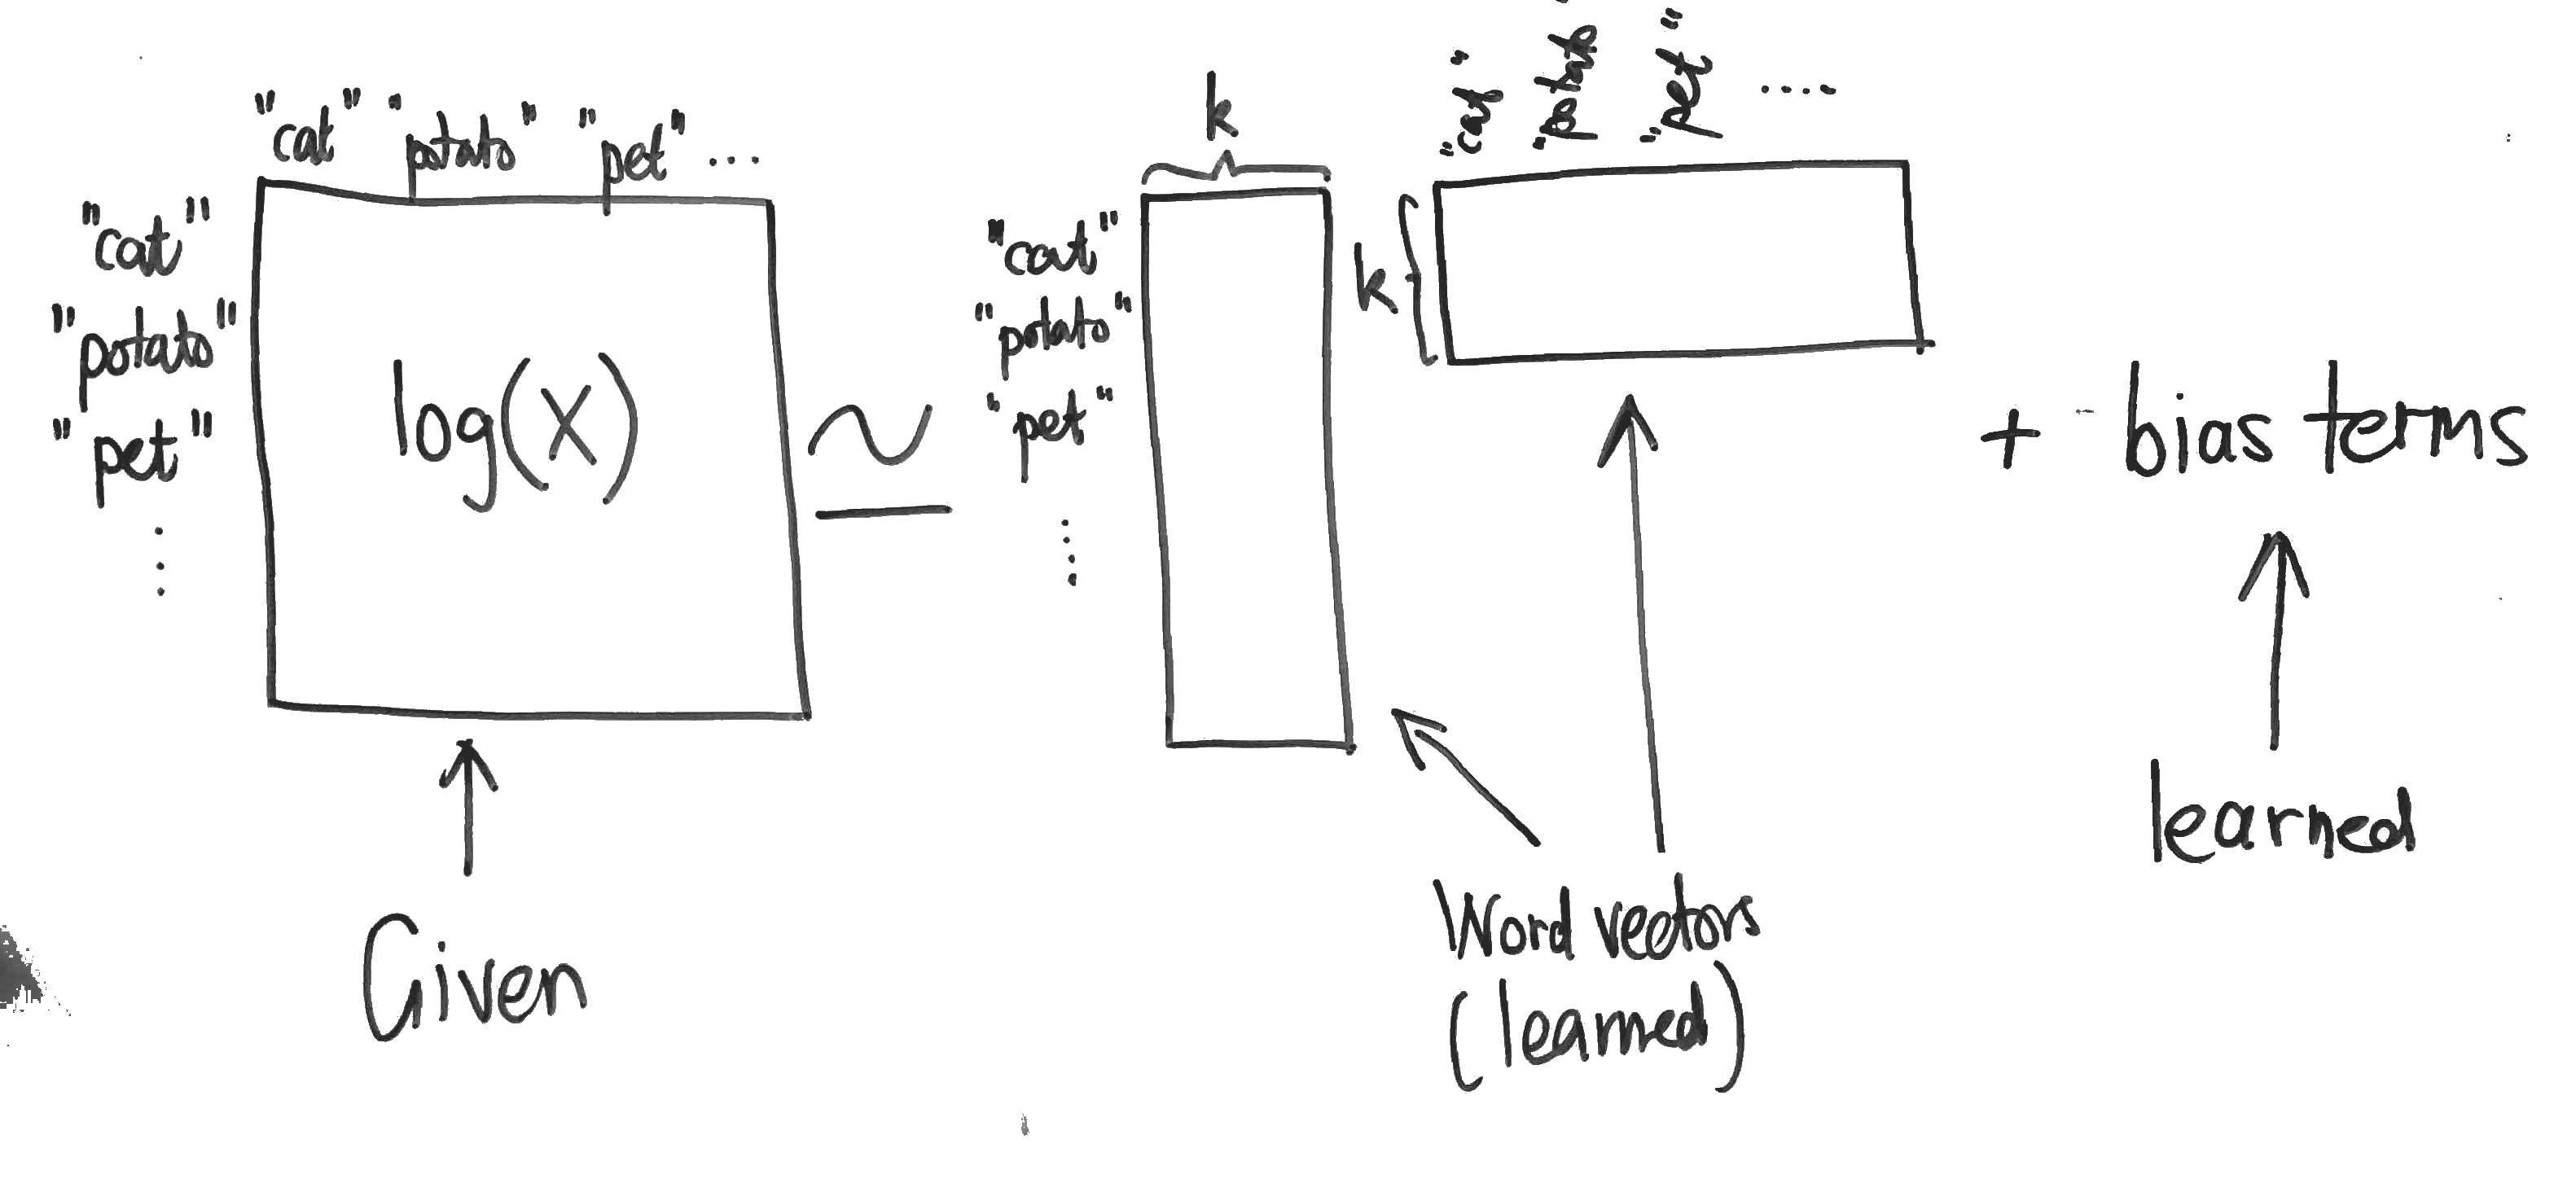

Чтобы реализовать всю эту красоту, потребуется алгоритм для матричной факторизации, а именно сингулярное разложение. Очень хорошиее объяснение можно найти [по ссылке](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf).

При работе с большими матрицами будет проблематично высчитать все собственные значения, поэтому как всегда в подобных случаях воспользуемся градиентным спуском. Функция потерь MSE.

Допишите реализацию.

In [ ]:
import numpy as np


def svd_gradient_descent(A, k, learning_rate=0.001, epochs=100):
    """
    Параметры:
    A (numpy.ndarray): Входная матрица (m, n).
    k (int): Количество сингулярных значений для вычисления.
    learning_rate (float): Скорость обучения для градиентного спуска.
    epochs (int): Количество итераций для градиентного спуска.

    Возвращает:
    U (numpy.ndarray): Левые сингулярные векторы (m, k).
    V_T (numpy.ndarray): Правые сингулярные векторы (k, n).
    """

    m, n = A.shape
    np.random.seed(42)
    U = np.random.randn(m, k)
    V_T = np.random.randn(k, n)
    for epoch in range(epochs):
        approx_A = U @ V_T
        error = A - approx_A

        grad_U = -2 * error @ V_T.T
        grad_V_T = -2 * U.T @ error

        U -= learning_rate * grad_U
        V_T -= learning_rate * grad_V_T

        loss = np.linalg.norm(A - U @ V_T, 'fro')**2
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return U, V_T

In [ ]:
print('-' * 50)

A = np.array([[3, 1, 1],
              [-1, 3, 1]])

U, V_T = svd_gradient_descent(A, k=2, learning_rate=0.1)
print("U:\n", U)
print("V_T:\n", V_T)
print("Result:\n", U @ V_T)

print('-' * 50)

A2 = np.array([[1, 2, 3],
               [4, 5, 6],
               [7, 8, 9]])

U2, V_T2 = svd_gradient_descent(A2, k=2, learning_rate=0.02, epochs=1000)
print("U2:\n", U2)
print("V_T2:\n", V_T2)
print("Result2:\n", U2 @ V_T2)

print('-' * 50)

--------------------------------------------------
Epoch 0, Loss: 16.6143
U:
 [[ 1.51006432 -0.16032515]
 [ 0.16252052  1.80591831]]
V_T:
 [[ 1.90963377  0.83065866  0.71419022]
 [-0.72558912  1.58645101  0.48946258]]
Result:
 [[ 3.  1.  1.]
 [-1.  3.  1.]]
--------------------------------------------------
Epoch 0, Loss: 263.8928
Epoch 100, Loss: 0.7302
Epoch 200, Loss: 0.0186
Epoch 300, Loss: 0.0002
Epoch 400, Loss: 0.0000
Epoch 500, Loss: 0.0000
Epoch 600, Loss: 0.0000
Epoch 700, Loss: 0.0000
Epoch 800, Loss: 0.0000
Epoch 900, Loss: 0.0000
U2:
 [[0.63599262 1.39670824]
 [1.96380033 0.73392099]
 [3.29160804 0.07113374]]
V_T2:
 [[ 2.13212866  2.42332448  2.7145203 ]
 [-0.25489796  0.32847485  0.91184765]]
Result2:
 [[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
--------------------------------------------------


Теперь реализуем сам алгоритм GloVe. Будем хранить матрицу со-встречаемости слов как разреженную матрицу (иначе не хватит оперативной памяти), а в качестве алгоритма для матричного разложения воспользуемся более оптимизированной, чем наша, версией "из коробки".

Сам код оформим в виде набора функций. Допишите реализацию.

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, lil_matrix
from collections import defaultdict
import itertools

def get_distinct_words(corpus):
    words = sorted(list(set(itertools.chain.from_iterable(corpus))))
    return words, len(words)

def compute_cooccurrence_matrix(corpus, window_size=1):
    words, n_words = get_distinct_words(corpus)
    word_to_index = {word: i for i, word in enumerate(words)}

    cooccurrence = lil_matrix((n_words, n_words), dtype=np.float32)

    for doc in corpus:
        for i, word in enumerate(doc):
            if word not in word_to_index:
                continue

            start = max(0, i - window_size)
            end = min(len(doc), i + window_size + 1)

            for j in range(start, end):
                if j == i or doc[j] not in word_to_index:
                    continue

                cooccurrence[word_to_index[word], word_to_index[doc[j]]] += 1.0 / abs(i - j)

    return cooccurrence.tocsr(), word_to_index

def normalize(M):
    M_lengths = np.linalg.norm(M, axis=1)
    M_normalized = M / (M_lengths[:, np.newaxis] + 1e-8)
    return M_normalized

def glove_embeddings(corpus, embedding_dim=100, window_size=5, n_iter=15):
    cooccurrence, word_to_index = compute_cooccurrence_matrix(corpus, window_size)
    words = list(word_to_index.keys())

    log_cooccurrence = cooccurrence.copy()
    log_cooccurrence.data = np.log(log_cooccurrence.data + 1.0)

    svd = TruncatedSVD(n_components=embedding_dim, n_iter=n_iter, random_state=42)
    embeddings = svd.fit_transform(log_cooccurrence)

    embeddings = normalize(embeddings)

    word_vectors = {word: embeddings[idx] for word, idx in word_to_index.items()}

    return word_vectors

In [ ]:
# Тесты

corpus = [["apple", "banana", "apple"], ["orange", "banana", "grape"]]
distinct_words, num_words = get_distinct_words(corpus)
assert distinct_words == ["apple", "banana", "grape", "orange"]
assert num_words == 4
print("get_distinct_words() works correctly!")

corpus = [["apple", "banana", "apple"], ["orange", "banana", "grape"]]
window_size = 1
M, word2ind = compute_cooccurrence_matrix(corpus, window_size)
expected_indices = {'apple': 0, 'banana': 1, 'grape': 2, 'orange': 3}
expected_matrix = [[0., 2., 0., 0.],
                    [2., 0., 1., 1.],
                    [0., 1., 0., 0.],
                    [0., 1., 0., 0.]]
assert word2ind == expected_indices
assert (M.toarray() == expected_matrix).all()
print("compute_cooccurrence_matrix() works correctly!")

get_distinct_words() works correctly!
compute_cooccurrence_matrix() works correctly!


У нас не слишком большое количество данных, тем не менее, модель чему-то выучивается. На всём массиве она обучается около 4 часов.

In [ ]:
# Уже обученная модель, чтобы не тратить время

!pip install --upgrade gdown
!gdown 1_-TnMejLJI78022kF2xDJo-bQgsCApL0
!gdown 1WHkeWrbxerj8HvAcemUuL4YwFbsiwSCj

Downloading...
From: https://drive.google.com/uc?id=1_-TnMejLJI78022kF2xDJo-bQgsCApL0
To: /content/cooccurrence_matrix.pickle
100% 11.3M/11.3M [00:00<00:00, 57.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WHkeWrbxerj8HvAcemUuL4YwFbsiwSCj
To: /content/word2ind.pickle
100% 1.28M/1.28M [00:00<00:00, 112MB/s]


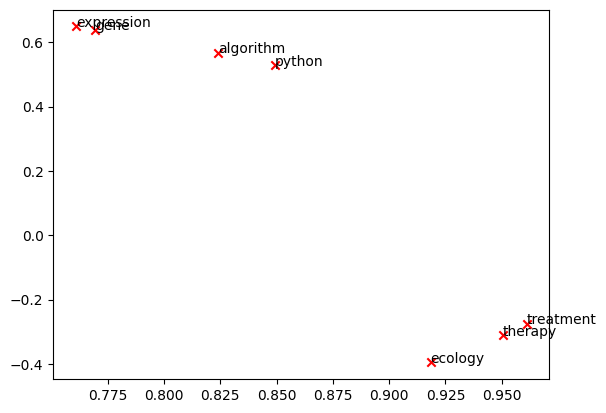

In [ ]:
import pickle


# corpus = df['title_abstract_preprocessed'].apply(lambda t: word_tokenize(t))
# M, word2ind = compute_cooccurrence_matrix(corpus, window_size=1)

with open("/content/cooccurrence_matrix.pickle", "rb") as f:
    M = pickle.load(f)
with open("/content/word2ind.pickle", "rb") as f:
    word2ind = pickle.load(f)

M_reduced =  TruncatedSVD(n_components=2).fit_transform(M)
embeddings = normalize(M_reduced)

for word in ['algorithm', 'ecology', 'expression', 'gene', 'python', 'treatment', 'therapy']:
    word_index = word2ind[word]
    word_embedding = embeddings[word_index]
    x, y = word_embedding[0], word_embedding[1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x, y, word, fontsize=10);

In [ ]:
len(word2ind)  # vocabulary size

82127

Для эмпирической оценки допишите функцию `most_similar`.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


def most_similar(word, embeddings, word2ind, top_n=5):
    """
    Находит наиболее похожие на данное слово слова на основе косинусного сходства их векторных представлений.

    Параметры:
        word (str): Слово, для которого нужно найти похожие слова.
        embeddings (numpy.ndarray): Векторные представления слов.
        word2ind (dict): Словарь, сопоставляющий слова их индексам в матрице векторных представлений.
        top_n (int): Количество наиболее похожих слов для возврата.

    Возвращает:
        list: Список кортежей, содержащих наиболее похожие слова и их оценки косинусного сходства.
    """

    if word not in word2ind:
        raise KeyError(f"Слово '{word}' отсутствует в словаре")

    word_idx = word2ind[word]
    word_vector = embeddings[word_idx].reshape(1, -1)

    similarities = cosine_similarity(word_vector, embeddings).flatten()

    top_indices = np.argsort(-similarities)[1:top_n+1]

    results = []
    for idx in top_indices:
        similar_word = list(word2ind.keys())[list(word2ind.values()).index(idx)]
        results.append((similar_word, similarities[idx]))

    return results

In [ ]:
M_reduced =  TruncatedSVD(n_components=312).fit_transform(M)
embeddings = normalize(M_reduced)

for word in ['algorithm', 'ecology', 'expression', 'gene', 'python', 'treatment']:
    print('-' * 50)
    print(word, end='\n\n')
    print(most_similar(word, embeddings, word2ind, top_n=10))

--------------------------------------------------
algorithm

[('method', np.float32(0.79887515)), ('approach', np.float32(0.7807468)), ('technique', np.float32(0.74874777)), ('procedure', np.float32(0.7150616)), ('scheme', np.float32(0.7042264)), ('heuristic', np.float32(0.6890002)), ('formulation', np.float32(0.65958863)), ('unsupervised', np.float32(0.6219592)), ('idea', np.float32(0.6170248)), ('model', np.float32(0.6129976))]
--------------------------------------------------
ecology

[('industrial', np.float32(0.5767239)), ('diversity', np.float32(0.56404924)), ('environment', np.float32(0.5626886)), ('behaviour', np.float32(0.5532096)), ('resource', np.float32(0.5304251)), ('transformation', np.float32(0.5261234)), ('evolution', np.float32(0.52388036)), ('law', np.float32(0.5225663)), ('ecological', np.float32(0.50932395)), ('theory', np.float32(0.50721693))]
--------------------------------------------------
expression

[('proteincode', np.float32(0.96738887)), ('atrophydetermi

Теперь взглянем на реализацию "из коробки".

In [ ]:
!pip uninstall -y gensim numpy
!pip install --upgrade numpy gensim

Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [ ]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")  # есть и другие модели, см. gensim.downloader.info()['models'].keys()
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

wv_from_bin = load_embedding_model()
for word in ['algorithm', 'ecology', 'expression', 'gene', 'python', 'treatment']:
    print('-' * 50)
    print(word, end='\n\n')
    print(wv_from_bin.most_similar(word, 10))

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000
--------------------------------------------------
algorithm

[('divide-and-conquer', 0.5534529089927673), ('krabat', 0.551224946975708), ('computes', 0.5506508946418762), ('jenalia.moreno@chron.com', 0.5458713173866272), ('fosterella', 0.5429463982582092), ('betterman', 0.540695071220398), ('starksia', 0.5393033623695374), ('algorithms', 0.5360755920410156), ('inugami', 0.5351618528366089), ('racinaea', 0.5292670130729675)]
--------------------------------------------------
ecology

[('icipe', 0.6646283864974976), ('zoogeography', 0.5999441742897034), ('ecofeminism', 0.5731804370880127), ('eco-systems', 0.546957790851593), ('energetics', 0.5300233364105225), ('palaeobiology', 0.5262896418571472), ('metapopulation', 0.5255571007728577), ('biogeochemistry', 0.5227234959602356), ('ecocriticism', 0.5164446234703064), ('afrofuturism', 0.5065551996231079)]
--------------------------

Далее задания из серии "поиграться". Во всех заданиях необходимо пояснить результаты (1-2 предложения).

1. Выберите какое-либо многозначное слово. Найдите его ближайших соседей.

2. Найдите тройку слов $(w_1,w_2,w_3)$ таких, что $w_1$ and $w_2$ синонимы, а $w_1$ и $w_3$ антонимы, но косинусное расстояние между первым и третьим меньше, чем между первым и вторым.

3. Есть ли в векторах предвзятость? Попробуйте привести пример.

In [ ]:
from pprint import pprint
pprint(wv_from_bin.most_similar('jam'))

[('jams', 0.6079556345939636),
 ('hop', 0.4473658502101898),
 ('band', 0.4384006857872009),
 ('rap', 0.4353543519973755),
 ('torbat-e', 0.43122220039367676),
 ('phish', 0.4302942156791687),
 ('nirvana', 0.4263398349285126),
 ('album', 0.4187255799770355),
 ('pop', 0.41468673944473267),
 ('raspberry', 0.4109961688518524)]


Найдены ближайшие соседи, темы отличаются, одни слова по теме варенье(jams, raspberry), другие слова относятся к музыке(band, rap,pop, album). То есть близкие слова взяты по обоим смыслам одного слова

In [ ]:
w1, w2, w3 = 'happy', 'joyful', 'unhappy'
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)
print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))
print()

Synonyms happy, joyful have cosine distance: 0.48148053884506226
Antonyms happy, unhappy have cosine distance: 0.38276076316833496



Антонимы находятся ближе к друг другу, это может быть вызвано похожими контекстами употребления, следовательно имеют схожие паттерны и оказываются ближе к друг другу

In [ ]:
A, B, C = 'woman', 'man', 'profession'
pprint(wv_from_bin.most_similar(positive=[A, C], negative=[B]))
print('------------------------------------------------------')
pprint(wv_from_bin.most_similar(positive=[B, C], negative=[A]))

[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]
------------------------------------------------------
[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]


Предвзятость выделяется в условно "женских" и "мужских" профессиях. Для женщин слова nursing, teacher, educator, для мужчин business, skill, reputation

Примените модель "из коробки" к вашим данным из OpenAlex так же, как в предыдущих заданиях. Оцените результаты. Вероятно, вам потребуется метод `get_mean_vector`.

Скорее всего, у вас не получится применить Наивный Байес. Почему?

                  precision    recall  f1-score   support

         Biology       0.86      0.75      0.80       397
Computer science       0.83      0.91      0.87       929
        Medicine       0.85      0.82      0.83       350
      Psychology       0.77      0.72      0.74       329

        accuracy                           0.83      2005
       macro avg       0.83      0.80      0.81      2005
    weighted avg       0.83      0.83      0.83      2005



Text(95.72222222222221, 0.5, 'True Label')

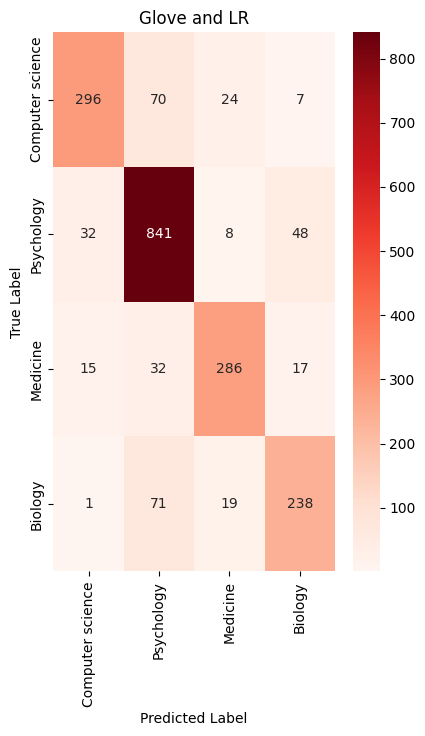

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from gensim.utils import simple_preprocess

df = pd.read_csv('openalex_domain_classification.csv')
X = df['title_abstract_preprocessed']
y = df['domain']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
def text_to_mean_vector(text):
    tokens = simple_preprocess(text)
    vectors = []
    for token in tokens:
        try:
            vectors.append(wv_from_bin[token])
        except KeyError:
            continue
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(wv_from_bin.vector_size)


X_vectors = np.array([text_to_mean_vector(text) for text in X])

X_train, X_test, y_train, y_test = train_test_split(X_vectors, y_encoded, test_size=0.2, random_state=42)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=df['domain'].unique(), yticklabels=df['domain'].unique())
plt.title("Glove and LR")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

Наивный Байес не подходит, так как он работает с дискретными счетными значениями,а в GloVe используется непрерывные значения.

## Самый главный вопрос (1 балл)

Возможно, вы уже задавались вопросом, откуда именно появились доменные метки в данных, с которыми вы работали. Если нет - самое время задуматься. Разметить вручную несколько миллионов статей - задача, близкая к невозможной.

Изучите документацию OpenAlex. Письменно ответьте на вопрос, каким образом записи получают метки, а также какое влияние это потенциально имеет на ваш пайплайн классификации. Есть ли связь с так называемым явлением feedback loop?

**Ответ:**

link: https://docs.openalex.org/api-entities/concepts

Концепции иерархичны, как дерево. Существует 19 корневых концепций и шесть слоев потомков, ответвляющихся от них, содержащих в общей сложности около 65 тысяч концепций.

Каждая работа помечена несколькими концепциями на основе названия, аннотации и названия принимающей площадки. Пометка выполняется с помощью автоматизированного классификатора, обученного на корпусе MAG

Для каждой концепции в работе доступна оценка , показывающая уверенность классификатора в выборе этой концепции. Однако при назначении дочерней концепции более низкого уровня мы также назначаем все ее родительские концепции вплоть до корня. Это означает, что некоторые оценки назначения концепций будут 0,0.

Это может оказывать влияние на нашу работу, так как этот подход создает потенциально предвзятые категории. Есть связь с feedback loop, а именно система задает замкнутый цикл, где предсказания модели влияют на будущую разметку.
